In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
import matplotlib.pyplot as plt
from src.evaluation.plot_utils import *
from collections import defaultdict

In [45]:
PLOT_DIR = "../experiments/plots"

BASE_DIR = "/Users/yavuz/scalable-multimodal-similarity-search/experiments/"
CONSTRUCTION_DIR = BASE_DIR + "construction/"
SEARCH_DIR = BASE_DIR + "search/"
EXACT_RESULTS_FOLDER = BASE_DIR + "exact_results/"
SAVED_INDEX_DIR = BASE_DIR + "saved_index/"
STATS_BASE_FOLDER = BASE_DIR + "stats-experiments/"


RERANK_CONSTRUCTION_DIR = BASE_DIR + "rerank_construction/"
RERANK_SEARCH_DIR = BASE_DIR + "rerank_search/"

SEARCH_WEIGHTS_DIR = BASE_DIR + "search_weights_exps/"

FIGURE_DPI = 200

In [47]:
import scienceplots
#plt.style.use([ 'science']) # 'notebook' 'science'

In [106]:
def get_search_weights_data(params, construction_params, base_folder=SEARCH_WEIGHTS_DIR, prev_experiment_folder=1, bracket_split_char="-"):
    folder = base_folder + get_construction_folder(params, bracket_split_char) + get_hnsw_construction_params_folder(construction_params, bracket_split_char)
    index_folder = get_latest_experiment_folder(folder)

    exps_folder = os.path.join(folder, index_folder)
    exp_folder = os.path.join(folder, index_folder, get_latest_experiment_folder(exps_folder, prev_experiment_folder))
    #get the last exp folder - maybe have k in the exp folder name as well, with time-

    search_weights_folders = os.listdir(exp_folder)

    search_weights_data = defaultdict(lambda: defaultdict(list)) # text_weight -> ef -> recall

    for search_weights_folder in search_weights_folders:
        if search_weights_folder.startswith("."):
            continue

        search_weights = search_weights_folder.split(bracket_split_char)[1]
        text_weight = float(search_weights.split(",")[0])

        for ef_folder in os.listdir(exp_folder + "/" + search_weights_folder):
            if ef_folder.startswith("."):
                continue
            stats = ef_folder.split("_")
            k = int(stats[0])
            ef = int(stats[1])

            if ef >=k:
                # load results.npz file
                results = np.load(os.path.join(exp_folder, search_weights_folder, ef_folder, "results.npz"))
                # results contains recall_scores, ef_search
                assert ef == results["ef_search"]
                search_weights_data[text_weight][ef].append(results["recall_scores"])

    print(f"Read values for k={k} for dataset size {params.index_size} for {len(search_weights_data[text_weight])} ef values")
    return search_weights_data, k

In [119]:
def plot_heatmap_for_search_weights_data(params, construction_params, search_weights_data, max_ef=float('inf'), plots_dir=PLOT_DIR):
    # search_weights_data is weights -> ef -> list of recall for 100 queries
    # we have 11 values for weights: 0.0 to 1.0, and around 15 for ef
    # for each cell combination, we plot a heatmap of the average of the recall values

    # we plot image weights, so first transform to 1-text_weight
    transformed_data = {}
    for weight, ef_dict in search_weights_data.items():
        new_weight = round(1.0 - weight, 5)
        transformed_data[new_weight] = ef_dict
    weights = sorted(transformed_data.keys())
    efs = sorted({ef for ef_dict in transformed_data.values() for ef in ef_dict if ef <= max_ef})

    heatmap_data = np.zeros((len(weights), len(efs)))

    for i, weight in enumerate(weights):
        for j, ef in enumerate(efs):
            recall_list = transformed_data[weight][ef]
            assert len(recall_list) > 0, f"Missing data for weight {weight} and ef {ef}"
            heatmap_data[i, j] = np.mean(recall_list)

    plt.figure(figsize=(10, 6))
    im = plt.imshow(heatmap_data, aspect='auto', origin='lower', cmap='viridis', vmax=1) #viridis, YlGn, summer

    plt.xticks(ticks=np.arange(len(efs)), labels=efs)
    plt.yticks(ticks=np.arange(len(weights)), labels=[f"{w:.1f}" for w in weights])

    plt.xlabel("efSearch")
    plt.ylabel("Image Search Weight (1 - Text Search Weight)")
    plt.title(f"Recall Heatmap on MultiVecHNSW with Index Weights [{round(params.weights[0], 5)}, {round(params.weights[1], 5)}]")

    plt.colorbar(im, label="Average Recall")

    plt.tight_layout()

    # save plot
    if not os.path.exists(f"{plots_dir}/search_weights"):
        os.makedirs(f"{plots_dir}/search_weights")
    print(params.weights[0],int(params.weights[0]*100))
    plt.savefig(f"{plots_dir}/search_weights/recall_heatmap_{params.index_size}_weight_{int(params.weights[0]*100)}_ef{construction_params.ef_construction}_seed_{construction_params.seed}_k{params.k}", dpi=FIGURE_DPI, bbox_inches='tight')

    plt.show()

In [120]:
search_weights_exp_params = Params(modalities=2, dimensions=[384, 768], metrics=["cosine", "cosine"], weights=[0.5, 0.5], index_size=100_000)
search_weights_construction_params = MultiVecHNSWConstructionParams(target_degree=16, max_degree=16, ef_construction=100, seed=3)

prev_experiment_folder = 1
search_weights_data, k = get_search_weights_data(search_weights_exp_params, search_weights_construction_params, prev_experiment_folder=prev_experiment_folder, bracket_split_char=":")
search_weights_exp_params.k = k

Read values for k=50 for dataset size 100000 for 26 ef values


0.5 50


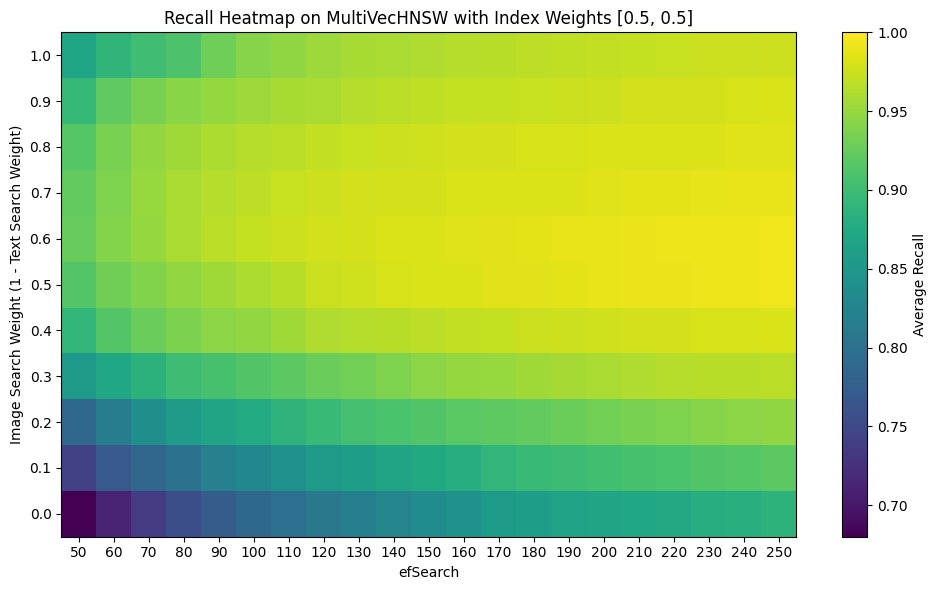

In [121]:
plot_heatmap_for_search_weights_data(search_weights_exp_params, search_weights_construction_params, search_weights_data, max_ef=250)

In [122]:
search_weights_exp_params = Params(modalities=2, dimensions=[384, 768], metrics=["cosine", "cosine"], weights=[0.5, 0.5], index_size=1_000_000)
search_weights_construction_params = MultiVecHNSWConstructionParams(target_degree=16, max_degree=16, ef_construction=100, seed=3)

prev_experiment_folder = 1
search_weights_data, k = get_search_weights_data(search_weights_exp_params, search_weights_construction_params, prev_experiment_folder=prev_experiment_folder, bracket_split_char=":")
search_weights_exp_params.k = k

Read values for k=50 for dataset size 1000000 for 36 ef values


0.5 50


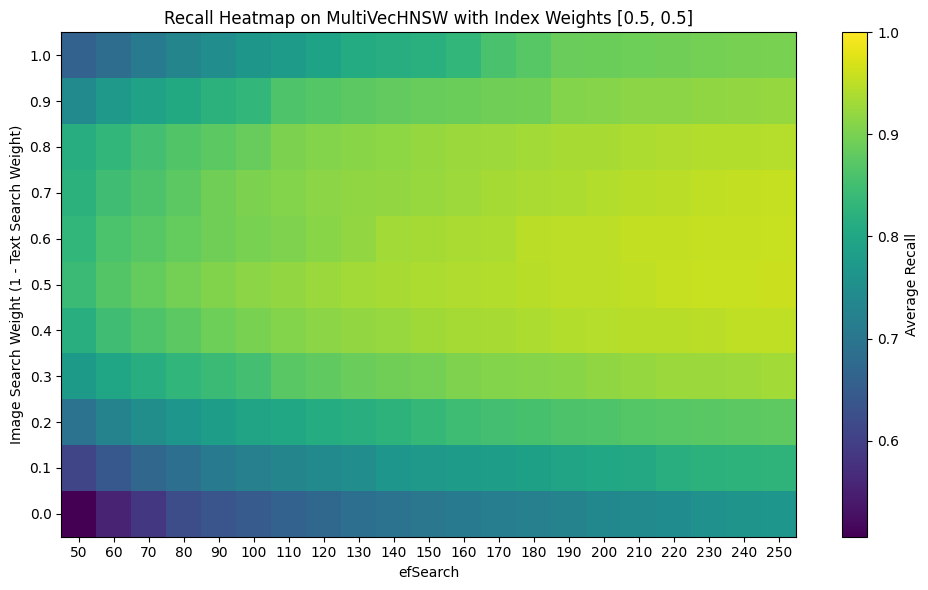

In [123]:
plot_heatmap_for_search_weights_data(search_weights_exp_params, search_weights_construction_params, search_weights_data, max_ef=250)

In [124]:
stats_search_exps_folder = STATS_BASE_FOLDER + "search_weights_exps/"

In [ ]:
for text_weight in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    search_weights_exp_params = Params(modalities=2, dimensions=[384, 768], metrics=["cosine", "cosine"], weights=[text_weight, round(1-text_weight, 5)], index_size=1_000_000)
    search_weights_construction_params = MultiVecHNSWConstructionParams(target_degree=16, max_degree=16, ef_construction=100, seed=60)

    prev_experiment_folder = 1
    search_weights_data, k = get_search_weights_data(search_weights_exp_params, search_weights_construction_params, base_folder=stats_search_exps_folder, prev_experiment_folder=prev_experiment_folder)
    search_weights_exp_params.k = k

    plot_heatmap_for_search_weights_data(search_weights_exp_params, search_weights_construction_params, search_weights_data, max_ef=250)


1.0 100


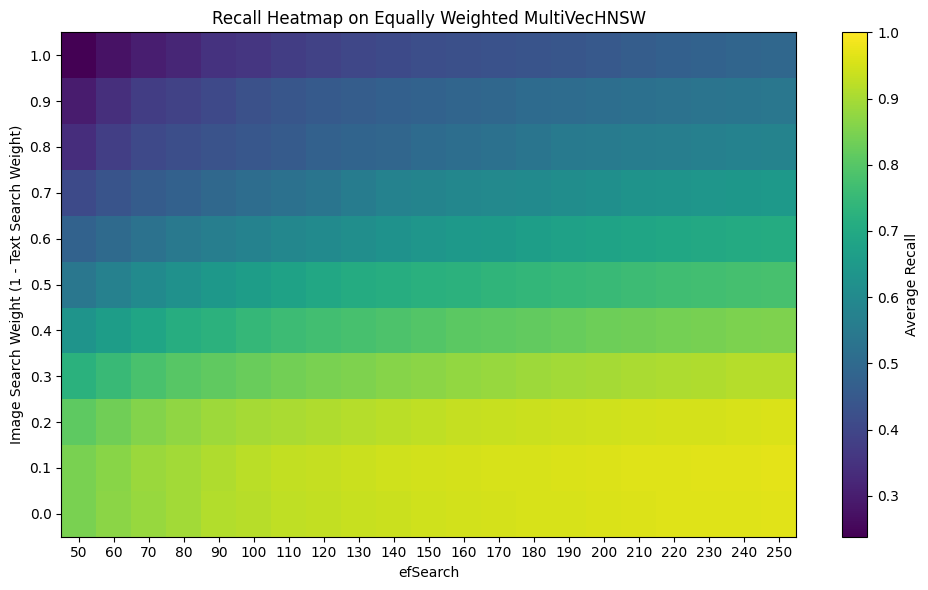